## Q1. Implement histogram equalization and apply to image people.png

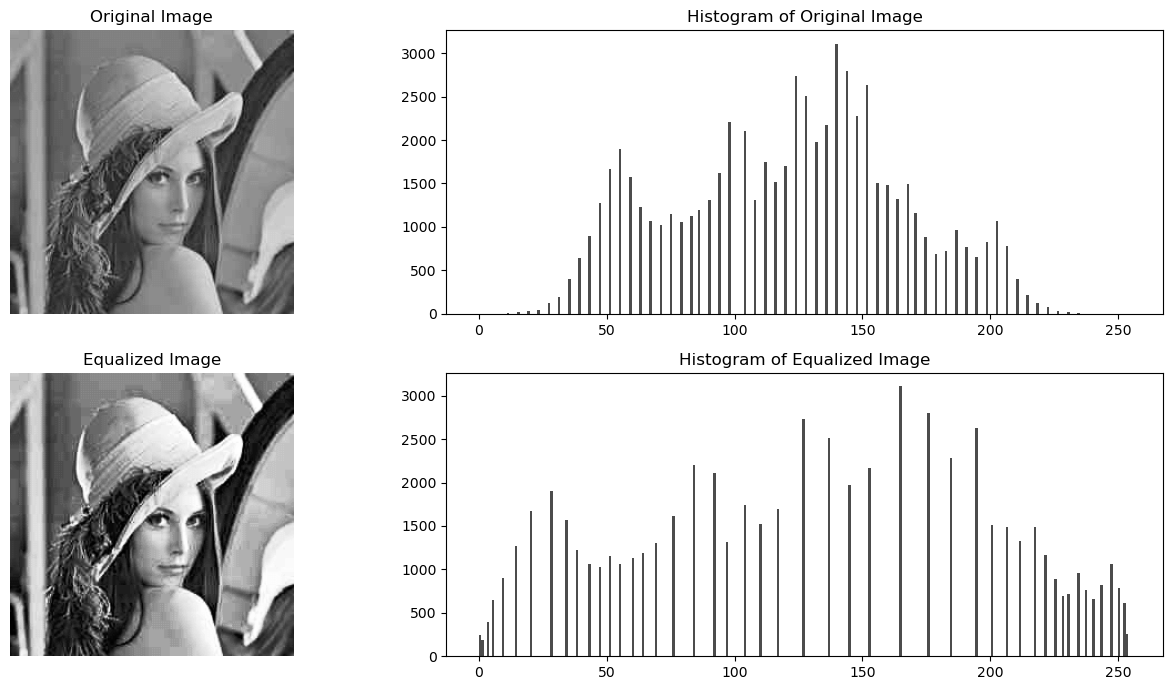

In [126]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def create_pdf(im_in):
    # Initialize histogram
    histogram = np.zeros(256, dtype=np.float32)
    # Calculate histogram
    height, width = im_in.shape
    for y in range(height):
        for x in range(width):
            pixel_value = im_in[y, x]
            histogram[pixel_value] += 1

    # Calculate probability density function (pdf)
    pdf = histogram / (height * width)

    return pdf

def create_cdf(pdf):
    # Calculate cumulative distribution function (cdf)
#     cdf = np.cumsum(pdf)
    cdf = np.zeros_like(pdf)
    cdf[0] = pdf[0]
    for i in range(1, len(pdf)):
        cdf[i] = cdf[i-1] + pdf[i]
    return cdf

def histogram_equalization(im_in):
    pdf = create_pdf(im_in)
    cdf = create_cdf(pdf)
    
    flattened_image = im_in.flatten()
    
    interpolated_values = np.zeros(flattened_image.shape)
    cdf *= 255
    for i in range(len(flattened_image)):
        interpolated_values[i] =  cdf[flattened_image[i]]
        
    equalized_im = interpolated_values.reshape(im_in.shape).astype(np.uint8)
    return equalized_im
#*******************************************************************************
# Read the image
image_path = 'people.png'
original_image = Image.open(image_path)
resized_image = original_image.resize((256, 256))
im = np.array(resized_image.convert('L'))
gray_image = ((im - np.min(im)) * (1 / (np.max(im) - np.min(im)) * 255)).astype('uint8')
# Perform histogram equalization
equalized_im = histogram_equalization(gray_image)

# Display original and equalized images
plt.figure(figsize=(14, 7))

# Plot the original image and its histogram
plt.subplot(2, 2, 1)
plt.imshow(gray_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.hist(gray_image.ravel(), bins=256, color='black', alpha=0.7)
plt.title('Histogram of Original Image')

# Plot the equalized image and its histogram
plt.subplot(2, 2, 3)
plt.imshow(equalized_im, cmap='gray')
plt.title('Equalized Image')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.hist(equalized_im.ravel(), bins=256, color='black', alpha=0.7)
plt.title('Histogram of Equalized Image')

plt.tight_layout()
plt.show()


# pdf_original = create_pdf(gray_image)
# cdf_original = create_cdf(pdf_original)

# pdf_equalized = create_pdf(equalized_im)
# cdf_equalized = create_cdf(pdf_equalized)

# # Plot CDFs side by side
# plt.figure(figsize=(12, 6))

# # Original Image CDF
# plt.subplot(1, 2, 1)
# plt.plot(cdf_original, color='blue')
# plt.title('Original Image CDF')
# plt.xlabel('Pixel Intensity')
# plt.ylabel('Cumulative Probability')

# # Equalized Image CDF
# plt.subplot(1, 2, 2)
# plt.plot(cdf_equalized, color='red')
# plt.title('Equalized Image CDF')
# plt.xlabel('Pixel Intensity')
# plt.ylabel('Cumulative Probability')


##  Q2.Implementing Otsu thresholding algorithm to generate binarized images

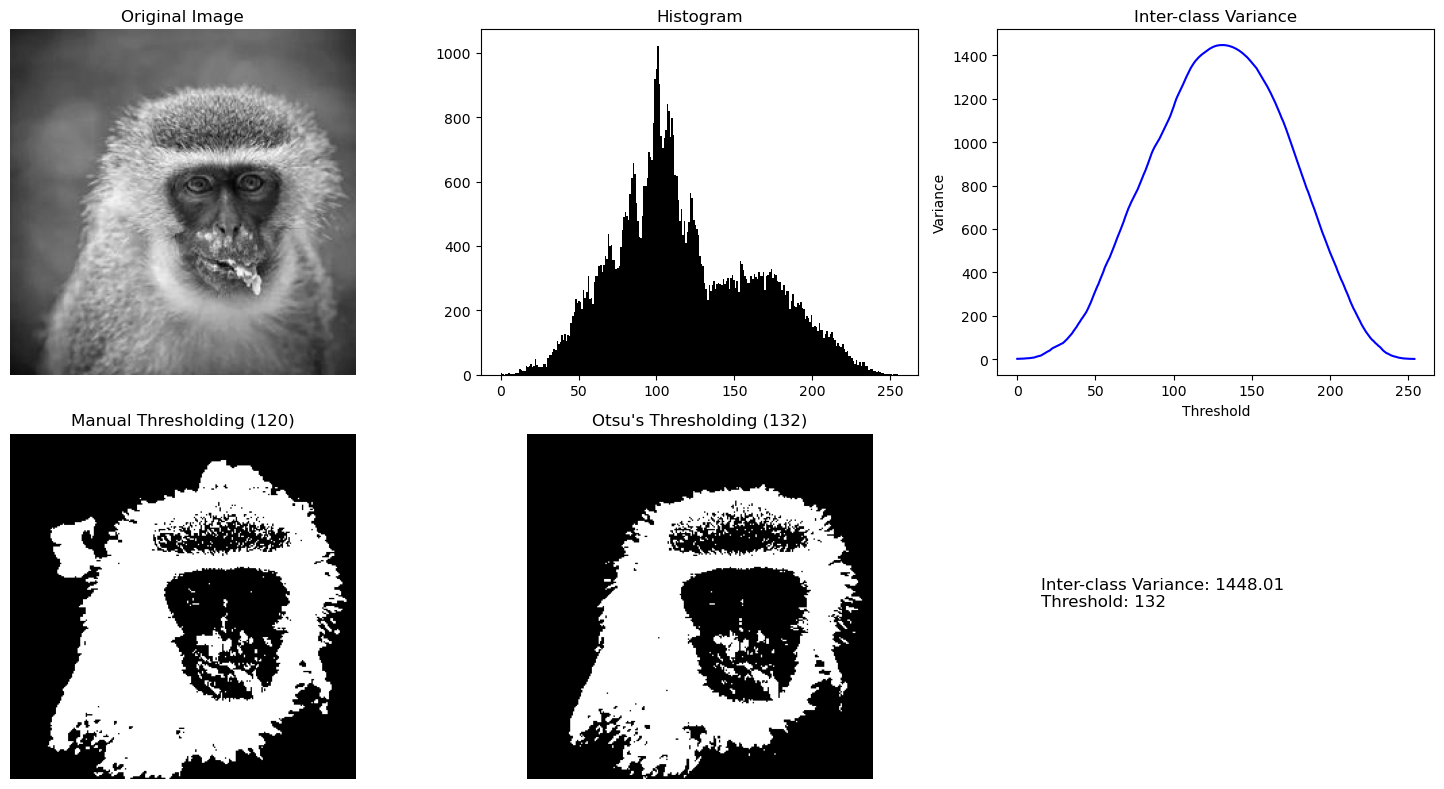

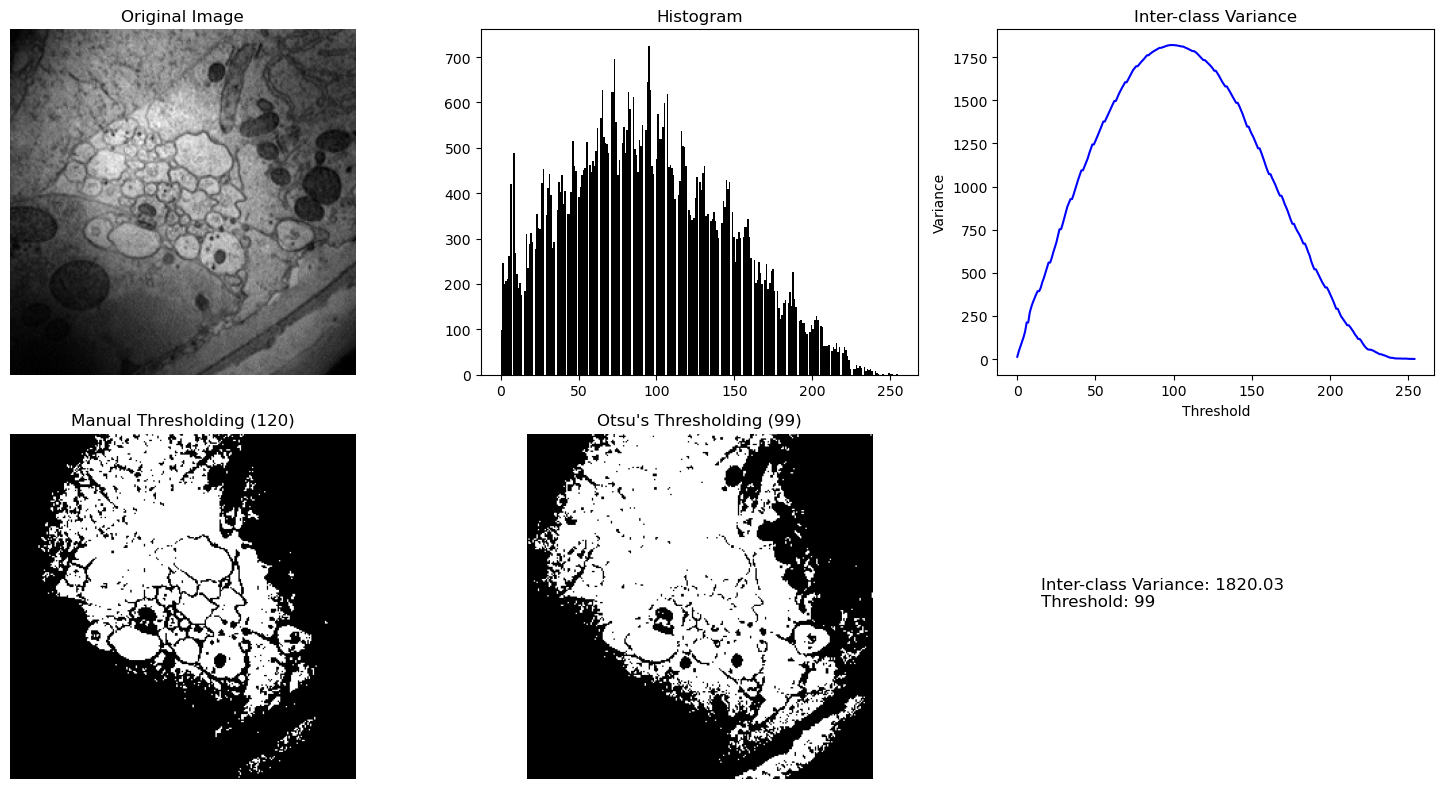

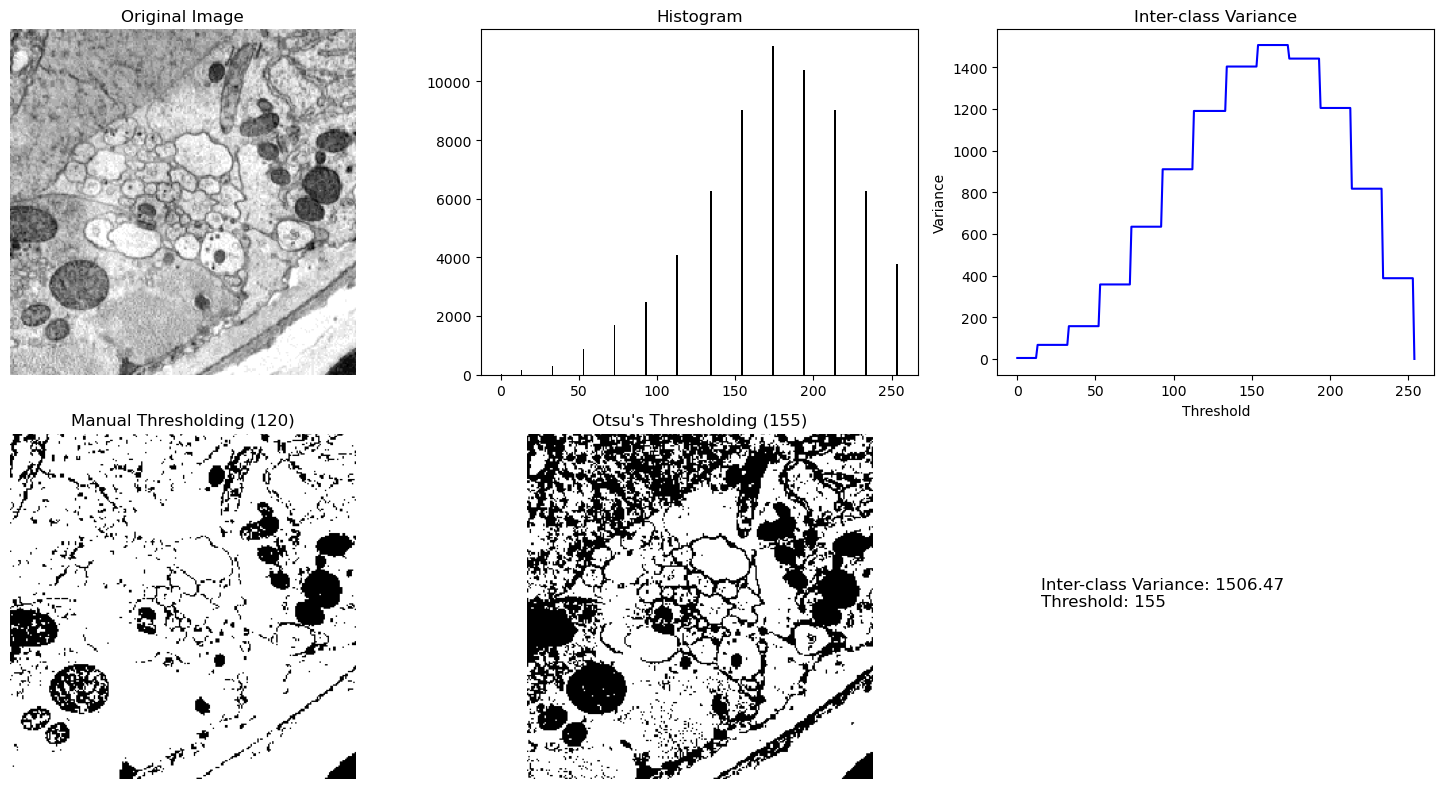

In [137]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def manual_threshold(im_in, threshold):
    manual_thresh_img = np.where(im_in >= threshold, 255, 0).astype(np.uint8)
    return manual_thresh_img
#**************************************************************************************
def otsu_threshold(im_in, pdf):
    

    # Initialize variables
    max_var = 0
    threshold = 0
    inter_class_varaiances = []
    # Iterate through all possible thresholds
    for t in range(1, 256):
        # Compute class probabilities and means
        w0 = np.sum(pdf[:t])
        w1 = np.sum(pdf[t:])
        epsilon = 1e-10
        w0 = max(w0, epsilon)
        w1 = max(w1, epsilon)
        mu0 = np.sum(np.arange(t) * pdf[:t]) / w0
        mu1 = np.sum(np.arange(t, 256) * pdf[t:]) / w1

        # Compute inter-class variance
        var = w0 * w1 * (mu0 - mu1) ** 2
        inter_class_varaiances.append(var)
        
        # Update threshold if variance is greater
        if var > max_var:
            max_var = var
            threshold = t

    # Threshold image
    otsu_thresh_img = np.where(im_in >= threshold, 255, 0).astype(np.uint8)

    return otsu_thresh_img, threshold, max_var, inter_class_varaiances

#**************************************************************************************
# Read images
image_paths = ['b2_a.png', 'b2_b.png', 'b2_c.png']
images = []

for path in image_paths:
    original_image = Image.open(path)
    resized_image = original_image.resize((256, 256))
    im = np.array(resized_image.convert('L'))
    im_uint8 = ((im - np.min(im)) * (1 / (np.max(im) - np.min(im)) * 255)).astype('uint8')
    images.append(im_uint8)

# Process each image
for i, image in enumerate(images):
    # Compute PDF
    pdf = create_pdf(image)

    # Manual thresholding
    manual_thresh_img = manual_threshold(image, 120)

    # Otsu's thresholding
    otsu_thresh_img, threshold, inter_class_variance, inter_class_varaiances = otsu_threshold(image, pdf)

    # Display results
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))

    # Original Image and Histogram
    axes[0, 0].imshow(image, cmap='gray')
    axes[0, 0].set_title('Original Image')
    axes[0, 0].axis('off')
    axes[0, 1].hist(image.ravel(), bins=256, color='black')
    axes[0, 1].set_title('Histogram')

    # Manual Thresholding
    axes[1, 0].imshow(manual_thresh_img, cmap='gray')
    axes[1, 0].set_title('Manual Thresholding (120)')
    axes[1, 0].axis('off')

    # Otsu's Thresholding
    axes[1, 1].imshow(otsu_thresh_img, cmap='gray')
    axes[1, 1].set_title(f"Otsu's Thresholding ({threshold})")
    axes[1, 1].axis('off')

    # Inter-class Variance Plot    
    thresholds = np.arange(255)
    variances = []
    for t in thresholds:
        _, _,_, variances = otsu_threshold(image, pdf)
    axes[0, 2].plot(thresholds, variances, color='blue')
    axes[0, 2].set_title('Inter-class Variance')
    axes[0, 2].set_xlabel('Threshold')
    axes[0, 2].set_ylabel('Variance')

    # Print inter-class variance and chosen threshold
    axes[1, 2].text(0.1, 0.5, f'Inter-class Variance: {inter_class_variance:.2f}\nThreshold: {threshold}', fontsize=12)
    axes[1, 2].axis('off')

    plt.tight_layout()
    plt.show()

## Q3.Histogram Matching

Got Test and Source CDF


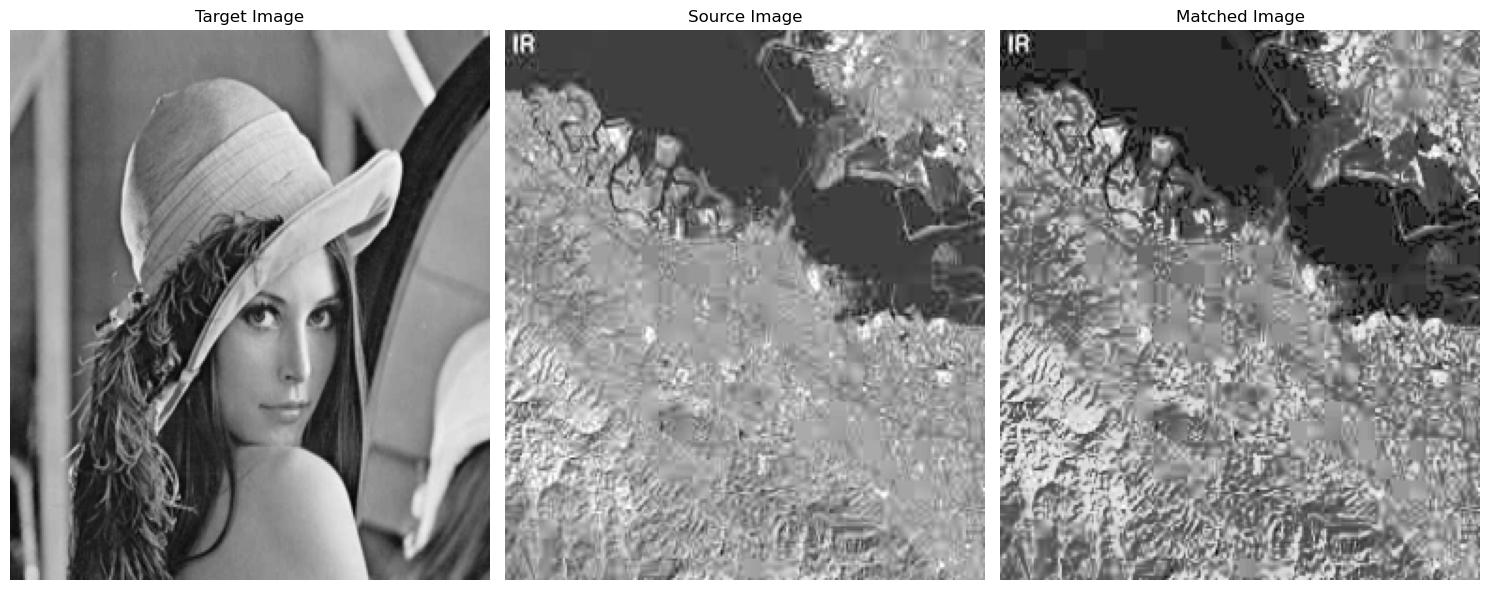

Got Test and Source CDF


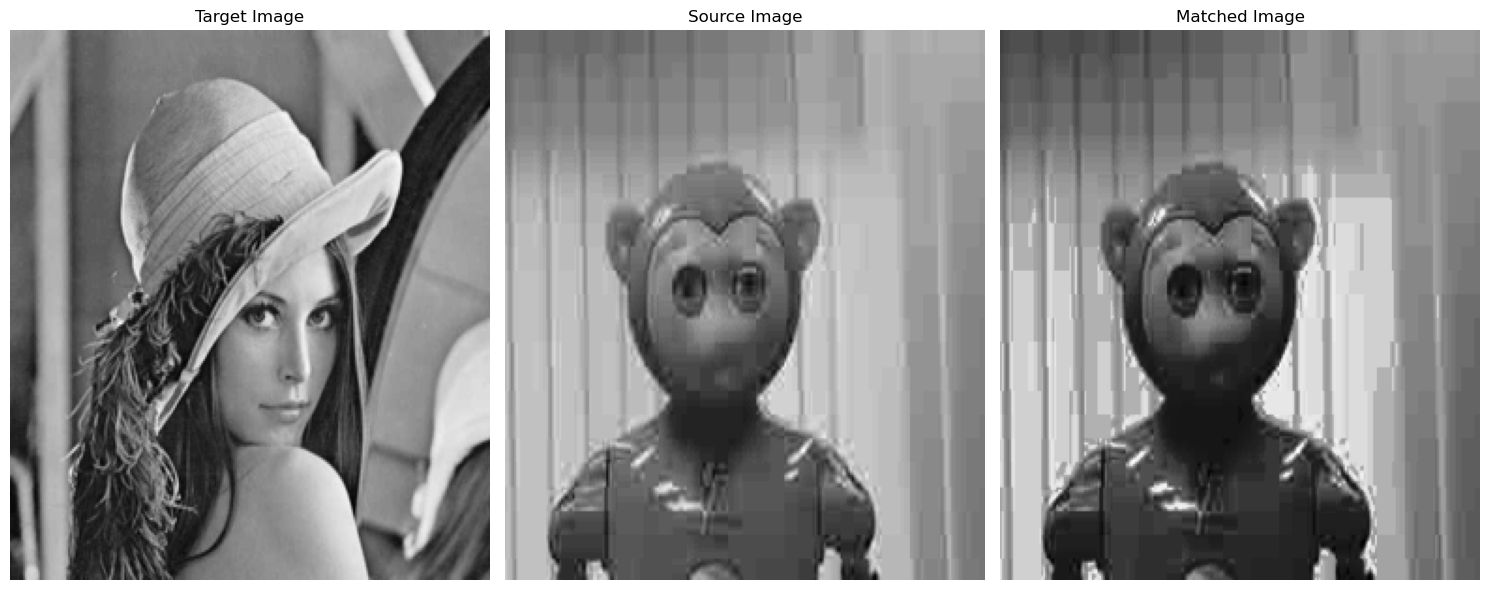

Got Test and Source CDF


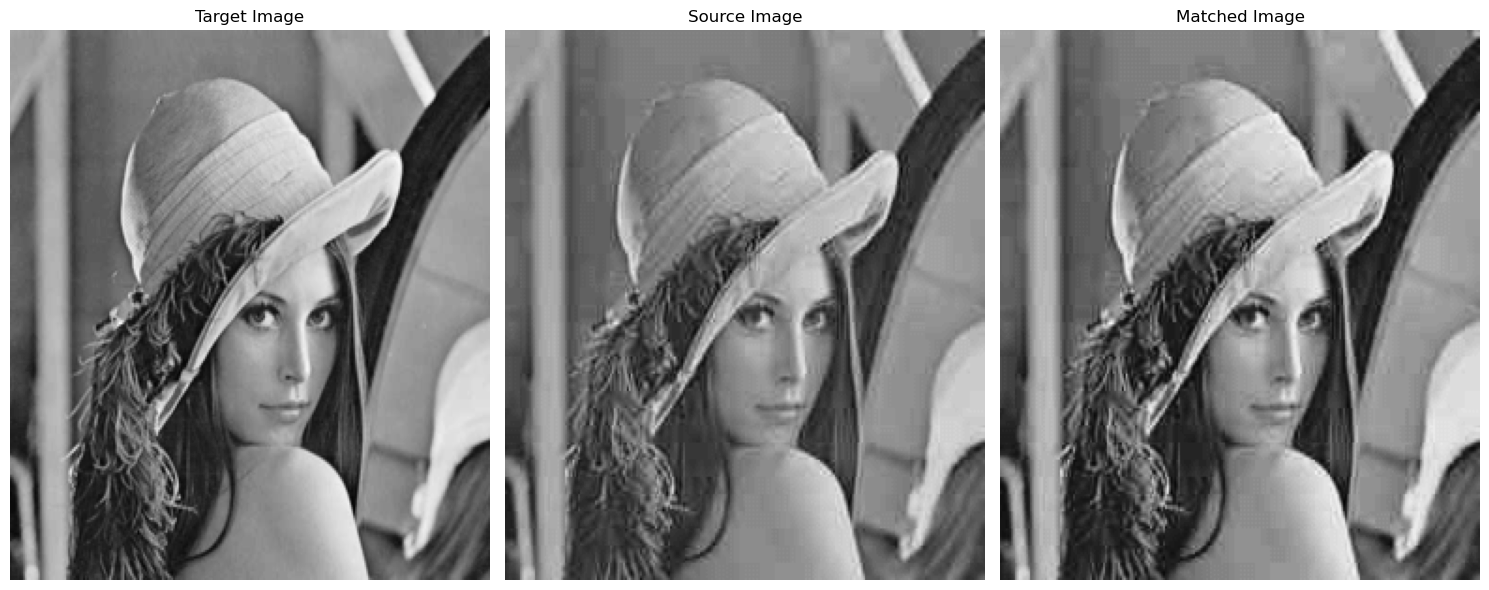

In [140]:
def create_pdf(im_in):
    # Initialize histogram
    histogram = np.zeros(256, dtype=np.float32)
    # Calculate histogram
    height, width = im_in.shape
    for y in range(height):
        for x in range(width):
            pixel_value = im_in[y, x]
            histogram[pixel_value] += 1

    # Calculate probability density function (pdf)
    pdf = histogram / (height * width)

    return pdf

def create_cdf(pdf):
    # Calculate cumulative distribution function (cdf)
#     cdf = np.cumsum(pdf)
    cdf = np.zeros_like(pdf)
    cdf[0] = pdf[0]
    for i in range(1, len(pdf)):
        cdf[i] = cdf[i-1] + pdf[i]
    return cdf

def histogram_matching(target,source):
    target_pdf = create_pdf(target)
    target_cdf = create_cdf(target_pdf)
    
    source_pdf = create_pdf(source)
    source_cdf = create_cdf(source_pdf)
    
    flattened_source = target.flatten()
    flattened_test = source.flatten()
    print("Got Test and Source CDF")
    interpolated_values = np.zeros(flattened_source.shape)
    
    mapping_function = np.zeros(256, dtype=np.uint8)

    # Linear interpolation to compute mapping function
    for i in range(256):
        j = 255
        while j >= 0 and target_cdf[j] > source_cdf[i]:
            j -= 1
        mapping_function[i] = j

    # Apply mapping function to source image
    matched_image = mapping_function[source]
    
#     mapping_function = np.interp(source_cdf, target_cdf, np.arange(256))

#     # Apply mapping function to source image
#     matched_image = mapping_function[source]

    return matched_image.astype(np.uint8)

#*******************************************************************************
image_path = 'target.png'
original_image = Image.open(image_path)
resized_image = original_image.resize((256, 256))
im = np.array(resized_image.convert('L'))
target = ((im - np.min(im)) * (1 / (np.max(im) - np.min(im)) * 255)).astype('uint8')

image_path = 'source3.png' # 'source2.png' 'source.png'
original_image = Image.open(image_path)
resized_image = original_image.resize((256, 256))
im = np.array(resized_image.convert('L'))
source = ((im - np.min(im)) * (1 / (np.max(im) - np.min(im)) * 255)).astype('uint8')

matched_image = histogram_matching(target,source)

plt.figure(figsize=(15, 6))

# Display Target Image
plt.subplot(1, 3, 1)
plt.imshow(target, cmap='gray', aspect='auto')  # Specify aspect ratio
plt.title('Target Image')
plt.axis('off')

# Display Source Image
plt.subplot(1, 3, 2)
plt.imshow(source, cmap='gray', aspect='auto')  # Specify aspect ratio
plt.title('Source Image')
plt.axis('off')

# Display Matched Image
plt.subplot(1, 3, 3)
plt.imshow(matched_image, cmap='gray', aspect='auto')  # Specify aspect ratio
plt.title('Matched Image')
plt.axis('off')

plt.tight_layout()  # Adjust layout for better visualization
plt.show()